# Adam

Adam是一个结合了动量法和RMSProp的优化算法， 兼具两者的优点

下面我们来实现一下Adam

In [1]:
def adam(parameters, vs, sqrs, t, lr = 1e-3, beta1 = 0.9, beta2 = 0.999):
    eps = 1e-10
    for param, v, sqr in zip(parameters, vs, sqrs):
        v[:] = beta1 * v + (1 - beta1) * param.grad.data
        sqr[:] = beta2 * sqr + (1 - beta2) * param.grad.data ** 2
        v_correct = v / (1 - beta1 ** t)
        sqr_correct = sqr / (1 - beta2 ** t)
        param.data = param.data - lr * (v_correct / torch.sqrt(sqr_correct + eps))

In [2]:
import numpy as np
import torch 
from torch.utils.data import DataLoader
from torch import nn
from torchvision.datasets import MNIST
import matplotlib.pyplot as plt
import time
%matplotlib inline

In [3]:
def data_tf(x):
    x = np.array(x, dtype = 'float32') / 255
    x = (x - 0.5) / 0.5
    x = x.reshape((-1,))
    x = torch.from_numpy(x)
    return x

In [4]:
train_set = MNIST('./data', train = True, transform = data_tf, download = True)
test_set = MNIST('./data', train = False, transform = data_tf, download = True)

In [5]:
critersion = nn.CrossEntropyLoss() #定义loss函数

In [6]:
train_data = DataLoader(train_set, batch_size = 64, shuffle = True)

In [7]:
#用Sequential定义一个三层网络
net = nn.Sequential(
    nn.Linear(784, 200),
    nn.ReLU(),
    nn.Linear(200, 100),
    nn.ReLU(),
    nn.Linear(100, 10))

In [8]:
#初始化梯度平方项和动量项
sqrs = []
vs = []
for param in net.parameters():
    sqrs.append(torch.zeros_like(param.data))
    vs.append(torch.zeros_like(param.data))

t = 1

In [10]:
#开始训练
losses = []
idx = 0
start = time.time()
for e in range(5):
    train_loss = 0
    for value, label in train_data:
        #前向传播
        out = net(value)
        loss = critersion(out, label)
        
        #反向传播
        net.zero_grad()
        loss.backward()
        adam(net.parameters(), vs, sqrs,t)
        t += 1
        
        #误差计算
        train_loss += loss.data.item()
        if idx % 30 == 0:
            losses.append(loss.data.item())
        idx += 1
    print('epoch:{}, train_loss:{:.6f}'.format(e, train_loss / len(train_data)))
end = time.time()
print('训练时间：{:.3f}'.format(end - start))

epoch:0, train_loss:0.349306
epoch:1, train_loss:0.156132
epoch:2, train_loss:0.116504
epoch:3, train_loss:0.093381
epoch:4, train_loss:0.080764
训练时间：125.518


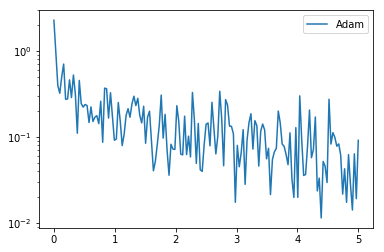

In [11]:
x_axis = np.linspace(0, 5, len(losses), endpoint = True)
plt.semilogy(x_axis, losses, label = 'Adam')
plt.legend(loc = 'best')

可以看到使用Adam算法能够时loss更快更好的收敛，但是一定要小心学习率的设定，使用自适应算法一般需要较小的学习率

pytorch中也内置了Adam的实现，只需要调用torch.optim.Adam,下面是例子

In [13]:
train_data = DataLoader(train_set, batch_size = 64, shuffle = True)
#尝试用module来实现神经网络
class module_net(nn.Module):
    def __init__(self):
        super(module_net, self).__init__()
        self.layer1 = nn.Linear(784, 200)
        self.layer2 = nn.ReLU()
        self.layer3 = nn.Linear(200, 10)
    
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        return x

In [16]:
mo_net = module_net()
optimizer = torch.optim.Adam(mo_net.parameters(), lr = 0.001) #定义优化器为Adam

In [19]:
#开始训练
start = time.time()
for e in range(5):
    train_loss = 0
    for value, label in train_data:
        #前向传播
        out = mo_net(value)
        loss = critersion(out, label)
        
        #反向传播
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        #误差计算
        train_loss += loss.data.item()
        
    print('epoch:{}, train_loss:{:.6f}'.format(e, train_loss / len(train_data)))
end = time.time()
print('训练时间:{}s'.format(end - start))

epoch:0, train_loss:0.169336
epoch:1, train_loss:0.123296
epoch:2, train_loss:0.102451
epoch:3, train_loss:0.085636
epoch:4, train_loss:0.075105
训练时间:78.15230941772461s
